## Import libraries

In [352]:
import pandas as pd
import numpy as np
import numpy
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn_pandas import CategoricalImputer
from sklearn.impute import SimpleImputer
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score

#### Load data into dataframe and replace "?" values with NaN

In [300]:
df = pd.read_csv('./input.csv', encoding='latin-1')
df = df.replace('?', numpy.NaN)

In [301]:
df.describe()

,C3,C8,C11,C15,Hired
count,690.000000,690.000000,690.00000,690.000000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507,0.444928
std,4.978163,3.346513,4.86294,5210.102598,0.497318
min,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,0.165000,0.00000,0.000000,0.000000
50%,2.750000,1.000000,0.00000,5.000000,0.000000
75%,7.207500,2.625000,3.00000,395.500000,1.000000
max,28.000000,28.500000,67.00000,100000.000000,1.000000


Column C15 is affected with outliers. We can remove outliers using IQR, values between lower quartile range(25) and upper quaritle range(75)

### Lets plot a count plot of class variable

Number of Hired(1) :  307
Number of not Hired(0):  383


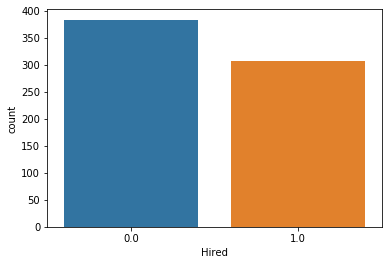

In [369]:
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
H, NH  = y.value_counts()
print('Number of Hired(1) : ',NH)
print('Number of not Hired(0): ',H)

### Impute features with most frequent values and LabelEncode the Categorical features

In [302]:
# Impute Categorical features with most frequent values for its columns
cat_features = df[['C1', 'C4', 'C5', 'C6', 'C7', 'C9', 'C10', 'C12', 'C13']]
# print("Features with nan values before Impute: \r\n", cat_features.isnull().sum())
cat_features = cat_features.fillna(cat_features.mode().iloc[0])
cat_features = cat_features.apply(LabelEncoder().fit_transform)
# print("\r\nFeatures with nan values after Impute: \r\n", cat_features.isnull().sum())
# cat_features.head(4)

### Apply OneHot encoder to categorical variables

In [298]:
# application = pd.get_dummies(cat_features, drop_first=True)
# application.head(4)

Categorical features with OneHot encoding doesn't give good results with RandomForestClassifier.<br/>
So, OneHot encoder is not used.

### Impute Numerical features with strategy 'mean'

In [303]:
# Impute Numerical features
ndf = pd.DataFrame({"C2": df.C2, "C3": df.C3, "C8": df.C8, "C11": df.C11, "C14": df.C14, "C15": df.C15, "Hired": df.Hired})
columns = ndf.columns.tolist()
# print("Features with nan values before Impute: \r\n", ndf.isnull().sum())

import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
ndf = imp_mean.fit_transform(ndf)
num_features = pd.DataFrame(ndf, columns=columns)
# print("\r\nFeatures with nan values after Impute: \r\n", num_features.isnull().sum())

### Combine both Numerical and Categorical features

In [315]:
newdf = pd.concat([num_features, cat_features], axis=1)
newdf.head(2)

,C2,C3,C8,C11,C14,C15,Hired,C1,C4,C5,C6,C7,C9,C10,C12,C13
0,30.83,0.00,1.25,1.0,202.0,0.0,1.0,1,1,0,12,7,1,1,0,0
1,58.67,4.46,3.04,6.0,43.0,560.0,1.0,0,1,0,10,3,1,1,0,0


### Lets check feature correlation between categorical features

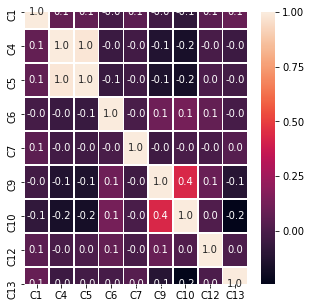

In [316]:
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cat_features.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

As we can seee C4 and C5 are correlated features, we can drop either of them.<br/>
Let choose C4 and drop C5

### Lets check feature correlation between numerical features

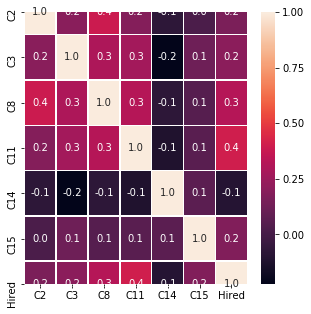

In [317]:
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(num_features.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Numericals features are not correlated to each other.

In [318]:
X = newdf.drop(['Hired'], axis=1)
y = newdf.Hired
feature_name = X.columns.tolist()

### Lets see correlations between features and target variables

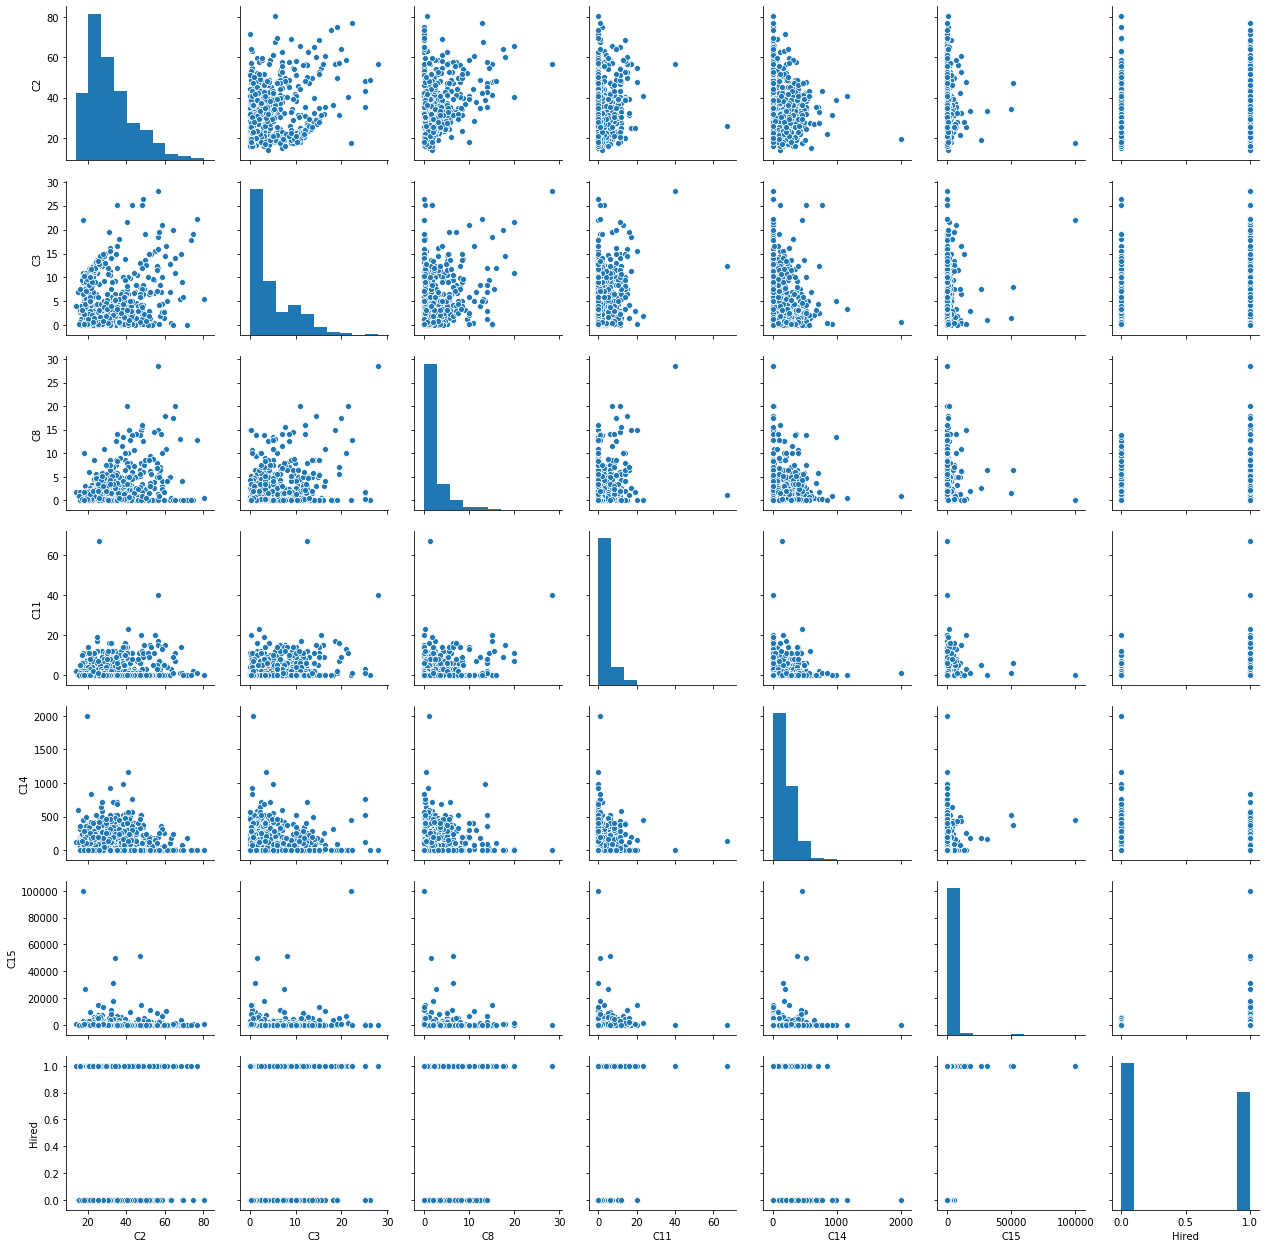

In [320]:
sns.pairplot(num_features)

As we can see the correlation between independent variables is low which is good for the model.<br/>
Highly correlated features results in high cpu usage and in some models it affects the overall model accuracy.

### Plot a pairplot to observe correlation between categorical variables

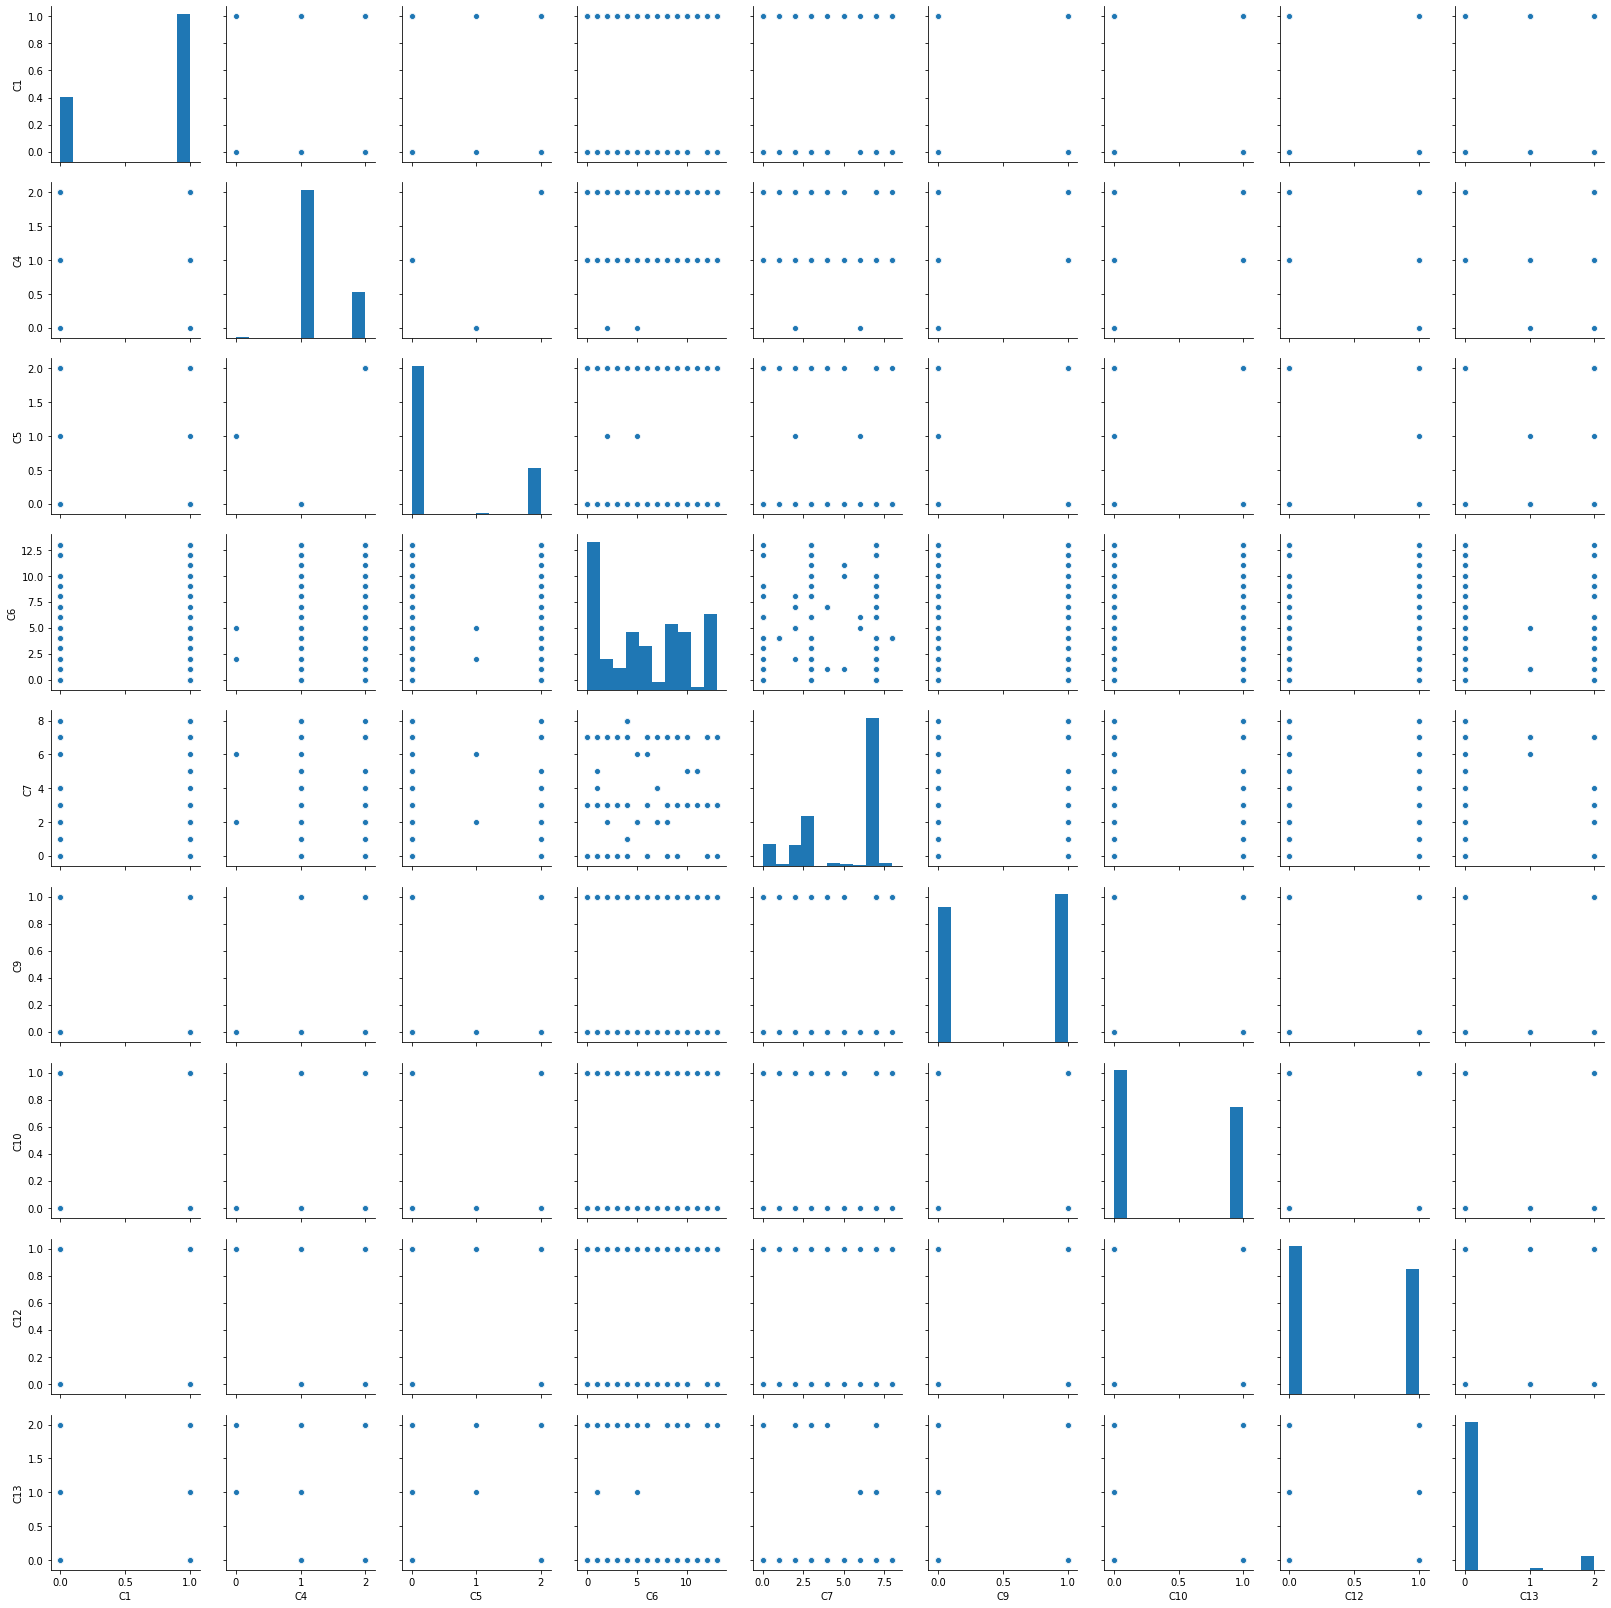

In [339]:
sns.pairplot(cat_features)

### Define a method to select the best features based on correlation coefficient

In [341]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [342]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

15 selected features


On the basis on correlation matrix, all of the features are good for our classifier.

### Let's use few Feature Selection techniques to choose the best features
1. SelectKBest
2. RFE
3. RFECV
4. RandomForestClassifier
5. PCA

In [244]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)
print('Score list:', select_feature.scores_)

print('\r\nFeature list:', x_train.columns)

Score list: [8.17488801e+01 8.73808292e+01 2.34329674e+02 8.09158004e+02
 3.58032743e+02 3.91245700e+05 3.13392857e-01 4.08787556e+00
 1.29307692e+01 1.30000000e+00 1.29307692e+01 4.68864469e-03
 1.07596923e+01 2.22307692e+00 6.19457014e-01 1.56201923e+01
 4.62457786e+00 1.75512821e+00 5.10787546e+00 1.44970414e-02
 9.09440559e+00 7.69230769e-01 1.16802413e+00 1.76923077e+01
 2.51282051e-01 1.77504472e+01 1.75424714e+01 2.30769231e+00
 1.25641026e-01 3.46153846e-02 3.65751563e-01 2.22527473e+00
 1.26447368e+02 5.67810427e+01 1.15294118e+00 2.22527473e+00
 7.24909502e+00]

Feature list: Index(['C2', 'C3', 'C8', 'C11', 'C14', 'C15', 'C1_b', 'C4_u', 'C4_y', 'C5_gg',
       'C5_p', 'C6_c', 'C6_cc', 'C6_d', 'C6_e', 'C6_ff', 'C6_i', 'C6_j',
       'C6_k', 'C6_m', 'C6_q', 'C6_r', 'C6_w', 'C6_x', 'C7_dd', 'C7_ff',
       'C7_h', 'C7_j', 'C7_n', 'C7_o', 'C7_v', 'C7_z', 'C9_t', 'C10_t',
       'C12_t', 'C13_p', 'C13_s'],
      dtype='object')


### We can select features based on this scores list by sorting in descending order

In [245]:
np.sort(select_feature.scores_)[::-1]

array([3.91245700e+05, 8.09158004e+02, 3.58032743e+02, 2.34329674e+02,
       1.26447368e+02, 8.73808292e+01, 8.17488801e+01, 5.67810427e+01,
       1.77504472e+01, 1.76923077e+01, 1.75424714e+01, 1.56201923e+01,
       1.29307692e+01, 1.29307692e+01, 1.07596923e+01, 9.09440559e+00,
       7.24909502e+00, 5.10787546e+00, 4.62457786e+00, 4.08787556e+00,
       2.30769231e+00, 2.22527473e+00, 2.22527473e+00, 2.22307692e+00,
       1.75512821e+00, 1.30000000e+00, 1.16802413e+00, 1.15294118e+00,
       7.69230769e-01, 6.19457014e-01, 3.65751563e-01, 3.13392857e-01,
       2.51282051e-01, 1.25641026e-01, 3.46153846e-02, 1.44970414e-02,
       4.68864469e-03])

### Choose best 10 features using RFE

In [246]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=10, step=1)
rfe = rfe.fit(x_train, y_train)
print('Chosen best 10 feature by rfe:',x_train.columns[rfe.support_])

D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarni

Chosen best 5 feature by rfe: Index(['C2', 'C3', 'C8', 'C11', 'C14', 'C15', 'C1_b', 'C5_p', 'C9_t', 'C10_t'], dtype='object')


In [326]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarni

D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarni

Optimal number of features : 7
Best features : Index(['C9_t', 'C8', 'C15', 'C2', 'C14', 'C3', 'C11'], dtype='object')


D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


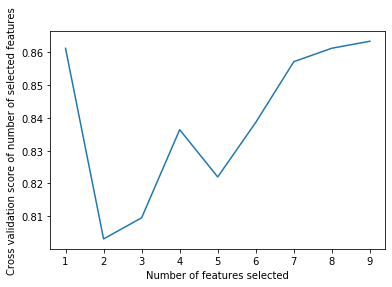

In [325]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Lets find out the best features using RandomForestClassifier

D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. feature 11 (0.202470)
2. feature 2 (0.171634)
3. feature 1 (0.100597)
4. feature 0 (0.092801)
5. feature 5 (0.090586)
6. feature 12 (0.083718)
7. feature 3 (0.066853)
8. feature 4 (0.064167)
9. feature 9 (0.039904)
10. feature 10 (0.024233)
11. feature 6 (0.017786)
12. feature 8 (0.016250)
13. feature 13 (0.011379)
14. feature 7 (0.010095)
15. feature 14 (0.007528)


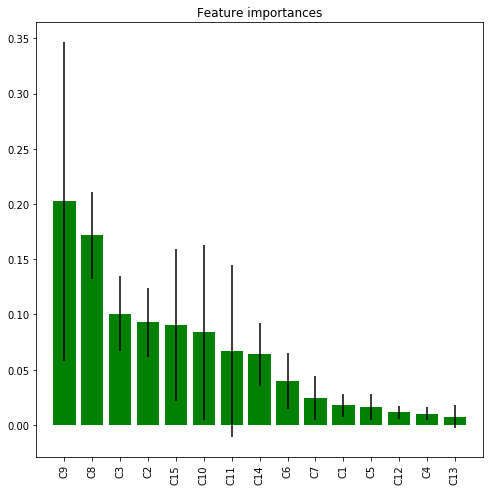

In [338]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

### PCA tells us number of features to select

Text(0, 0.5, 'explained_variance_ratio_')

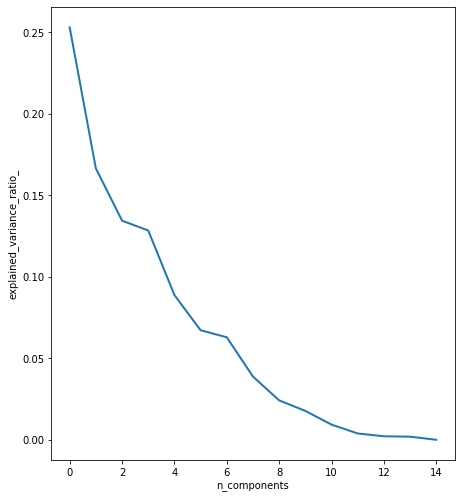

In [337]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#normalization
x_train_N = (x_train-x_train.mean())/(x_train.max()-x_train.min())
x_test_N = (x_test-x_test.mean())/(x_test.max()-x_test.min())

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_N)

plt.figure(1, figsize=(8, 9))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

### Spit the dataset into train/test and apply RandomForestClassifer

D:\surinder\envs\spark\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train accuracy:  0.989648033126294
Test accuracy:  0.8405797101449275
F1 Score:  0.8400539300186651
Confusion matrix: 
 [[97 13]
 [20 77]]

AUC Curve


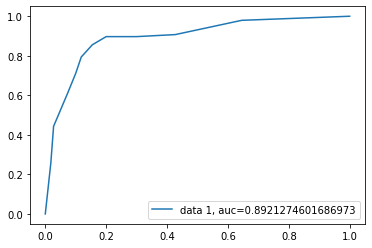

In [374]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

Xa = X.drop(['C4', "C5", "C1"], axis=1)
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

print("Train accuracy: ", accuracy_score(y_train, clr_rf.predict(x_train)))
print('Test accuracy: ',accuracy_score(y_test, clf_rf.predict(x_test)))
print('F1 Score: ', f1_score(y_test, clf_rf.predict(x_test) ,average='weighted'))

cm = confusion_matrix(y_test,clf_rf.predict(x_test))
print("Confusion matrix: \r\n", cm)

# Draw an AUC/ROC curve
print('\r\nAUC Curve')
y_pred_proba = clr_rf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

RandomForest model has achieved good accuracy because of categorical features.<br/>

### Tune the RandomForestClassifier using GridSearchCV

In [355]:
param_grid3 = {"n_estimators": [5, 40, 42],
              "max_depth": [5, 6],
              "min_samples_split": [5, 10],
              "min_samples_leaf": [3, 5],
              "max_leaf_nodes": [14, 15]}

grid_search = GridSearchCV(clf_rf, param_grid=param_grid3)
grid_search.fit(x_train, y_train)
grid_search

D:\surinder\envs\spark\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=43,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [362]:
print("Best params: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)

Best params:  {'max_depth': 6, 'max_leaf_nodes': 14, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 5}
Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=14,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=43, verbose=0,
                       warm_start=False)
